<a href="https://colab.research.google.com/github/raspopovaa/Pet-Project-Data-Analyst/blob/main/%D0%9F%D1%80%D0%B8%D0%BD%D1%8F%D1%82%D0%B8%D0%B5_%D1%80%D0%B5%D1%88%D0%B5%D0%BD%D0%B8%D0%B9_%D0%B2_%D0%B1%D0%B8%D0%B7%D0%BD%D0%B5%D1%81%D0%B5_%D0%BD%D0%B0_%D0%BE%D1%81%D0%BD%D0%BE%D0%B2%D0%B5_%D0%B4%D0%B0%D0%BD%D0%BD%D1%8B%D1%85.%D0%90%D0%92_%D1%82%D0%B5%D1%81%D1%82%D1%8B/%D0%90%D0%92_%D1%82%D0%B5%D1%81%D1%82.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Предобработка данных

Импортируем необходимые библиотеки.

In [ ]:
import pandas as pd
import numpy as np
import datetime as dt

from scipy import stats
from statsmodels.stats.proportion import proportions_ztest

%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

from datetime import date, time, timedelta

from tqdm import tqdm

Загружем дата сеты.

In [ ]:
try:
    dfh= pd.read_csv('/datasets/hypothesis.csv')
except:
    dfh= pd.read_csv('https://code.s3.yandex.net/datasets/hypothesis.csv')
try:
    orders = pd.read_csv('/datasets/orders.csv', parse_dates=['date'])
except:
    orders = pd.read_csv('https://code.s3.yandex.net/datasets/orders.csv', parse_dates=['date'])# меняем тип данных столбца data на datetime64[ns]     
try:
    visitors= pd.read_csv('/datasets/visitors.csv', parse_dates=['date'])
except:
    visitors= pd.read_csv('https://code.s3.yandex.net/datasets/visitors.csv', parse_dates=['date'])# меняем тип данных столбца data на datetime64[ns]     
    
    
# устанавливаем отображение количества столбцов экране 
pd.options.display.max_columns = 40
pd.options.display.max_colwidth = 150
pd.options.display.float_format = '{:.2f}'.format # устанавливаем отображение числа знаков после точки.
import warnings
warnings.filterwarnings('ignore')

В таблице dfh запишем названия столцов строчными буквами.

In [ ]:
dfh.columns = dfh.columns.str.lower()
dfh.head(10)

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


Рассмотрим таблицу orders

In [ ]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1197 non-null   int64         
 1   visitorId      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   int64         
 4   group          1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


In [ ]:
orders.duplicated().sum()

0

Пропусков нет, дублей нет. Тип данных в столбце date нужно заменить на date.        

In [ ]:
orders['date'] = pd.to_datetime(orders['date'])
orders['date'].describe()

count                    1197
unique                     31
top       2019-08-05 00:00:00
freq                       48
first     2019-08-01 00:00:00
last      2019-08-31 00:00:00
Name: date, dtype: object

In [ ]:
orders.groupby('group')['visitorId'].nunique()

group
A    503
B    586
Name: visitorId, dtype: int64

Присутствует некорректное деление трафика, пользователей категории В на 15% больше чем категории А. Это нормально, то что в одной группе больше участников, чем в другой. Это не говорит о некорректности теста, лишь о его не оптимальности. Чем больше разница между количество участников, тем дольше будет идти этап подготовки к тесту. Продолжаем анализ. 

Рассмотрим таблицу visitors

In [ ]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


In [ ]:
visitors.duplicated().sum()

0

### Вывод

Использовав метод info и duplicated, можно сделать вывод, что таблицы не содержать пропусков и дубликатов. Столбцы имеют разный тип данных. Таблица удобная для анализа данных - в каждом столбце хранятся значения, каждая строка содержит одно наблюдение, к которому привязаны значения разных переменных. Название столбцов без пробелов, на одном языке и в одном регистре, отображают в краткой форме какого рода информация содержится в каждом столбце. Тип данных столбце date в обеих таблицах изменили на datetime64 при загрузке данных. Период данных в обеих талицах совпадает с 01/08 по 31/08. Данные готовы для анализа.

##  Приоритизация гипотез.

### Примените фреймворк ICE для приоритизации гипотез. Отсортируйте их по убыванию приоритета.

In [ ]:
dfh['ICE'] = (dfh['impact'] * dfh['confidence']) / dfh['efforts']
dfh.loc[:,['hypothesis', 'ICE']].sort_values(by = 'ICE', ascending=False)

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


Используя метод ICE мы видим, что 8,0,7 гипотезы наиболее приоритетны.

### Примените фреймворк RICE для приоритизации гипотез. Отсортируйте их по убыванию приоритета.

In [ ]:
dfh['RICE'] = (dfh['reach'] * dfh['impact'] * dfh['confidence']) / dfh['efforts']
dfh.loc[:,['hypothesis', 'RICE']].sort_values(by = 'RICE', ascending=False)


,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.00
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.00
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.00
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.00
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.00


Используя метод RICE, в приоритете оказалить 7,2,0 гипотезы.

### Укажите, как изменилась приоритизация гипотез при применении RICE вместо ICE. Объясните, почему так произошло.

In [ ]:
dfh

,hypothesis,reach,impact,confidence,efforts,ICE,RICE
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33,40.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00,4.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00,56.00
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12,9.00
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00,3.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33,4.00
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00,40.00
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20,112.00
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20,16.20


В приоретет вышла 7 гипотеза, в связи с тем, что параметр reach равен 10, в то время как у других он меньше. При выборе гипотезы нужно учитывать сколько людей она затронет.  

По моему мнению, выбор нужной гипотезы очень индивидуальное дело, везде будет по разному и зависеть от текущих целей компании. В данном случае я бы выбрал метод RICE и соответственно топ -3 гипотезы:
    
    * Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок	
    * Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа	
    * Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей	
Данные гипотезы будут наиболее эффективны.

## Анализ A/B-теста

In [ ]:
orders.head(5)

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [ ]:
visitors.head(5)

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


### Построим график кумулятивной выручки по группам.

Создадим массив уникальных пар значений дат и групп теста.

In [ ]:
datesGroups = orders[['date','group']].drop_duplicates() 

Соберём агрегированные кумулятивные по дням данные о заказах в несколько действий.

In [ ]:
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]\
.agg({'date' : 'max', 'group' : 'max', 'transactionId' : pd.Series.nunique, 'visitorId' : pd.Series.nunique, 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']
cumulativeData.head(5)

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


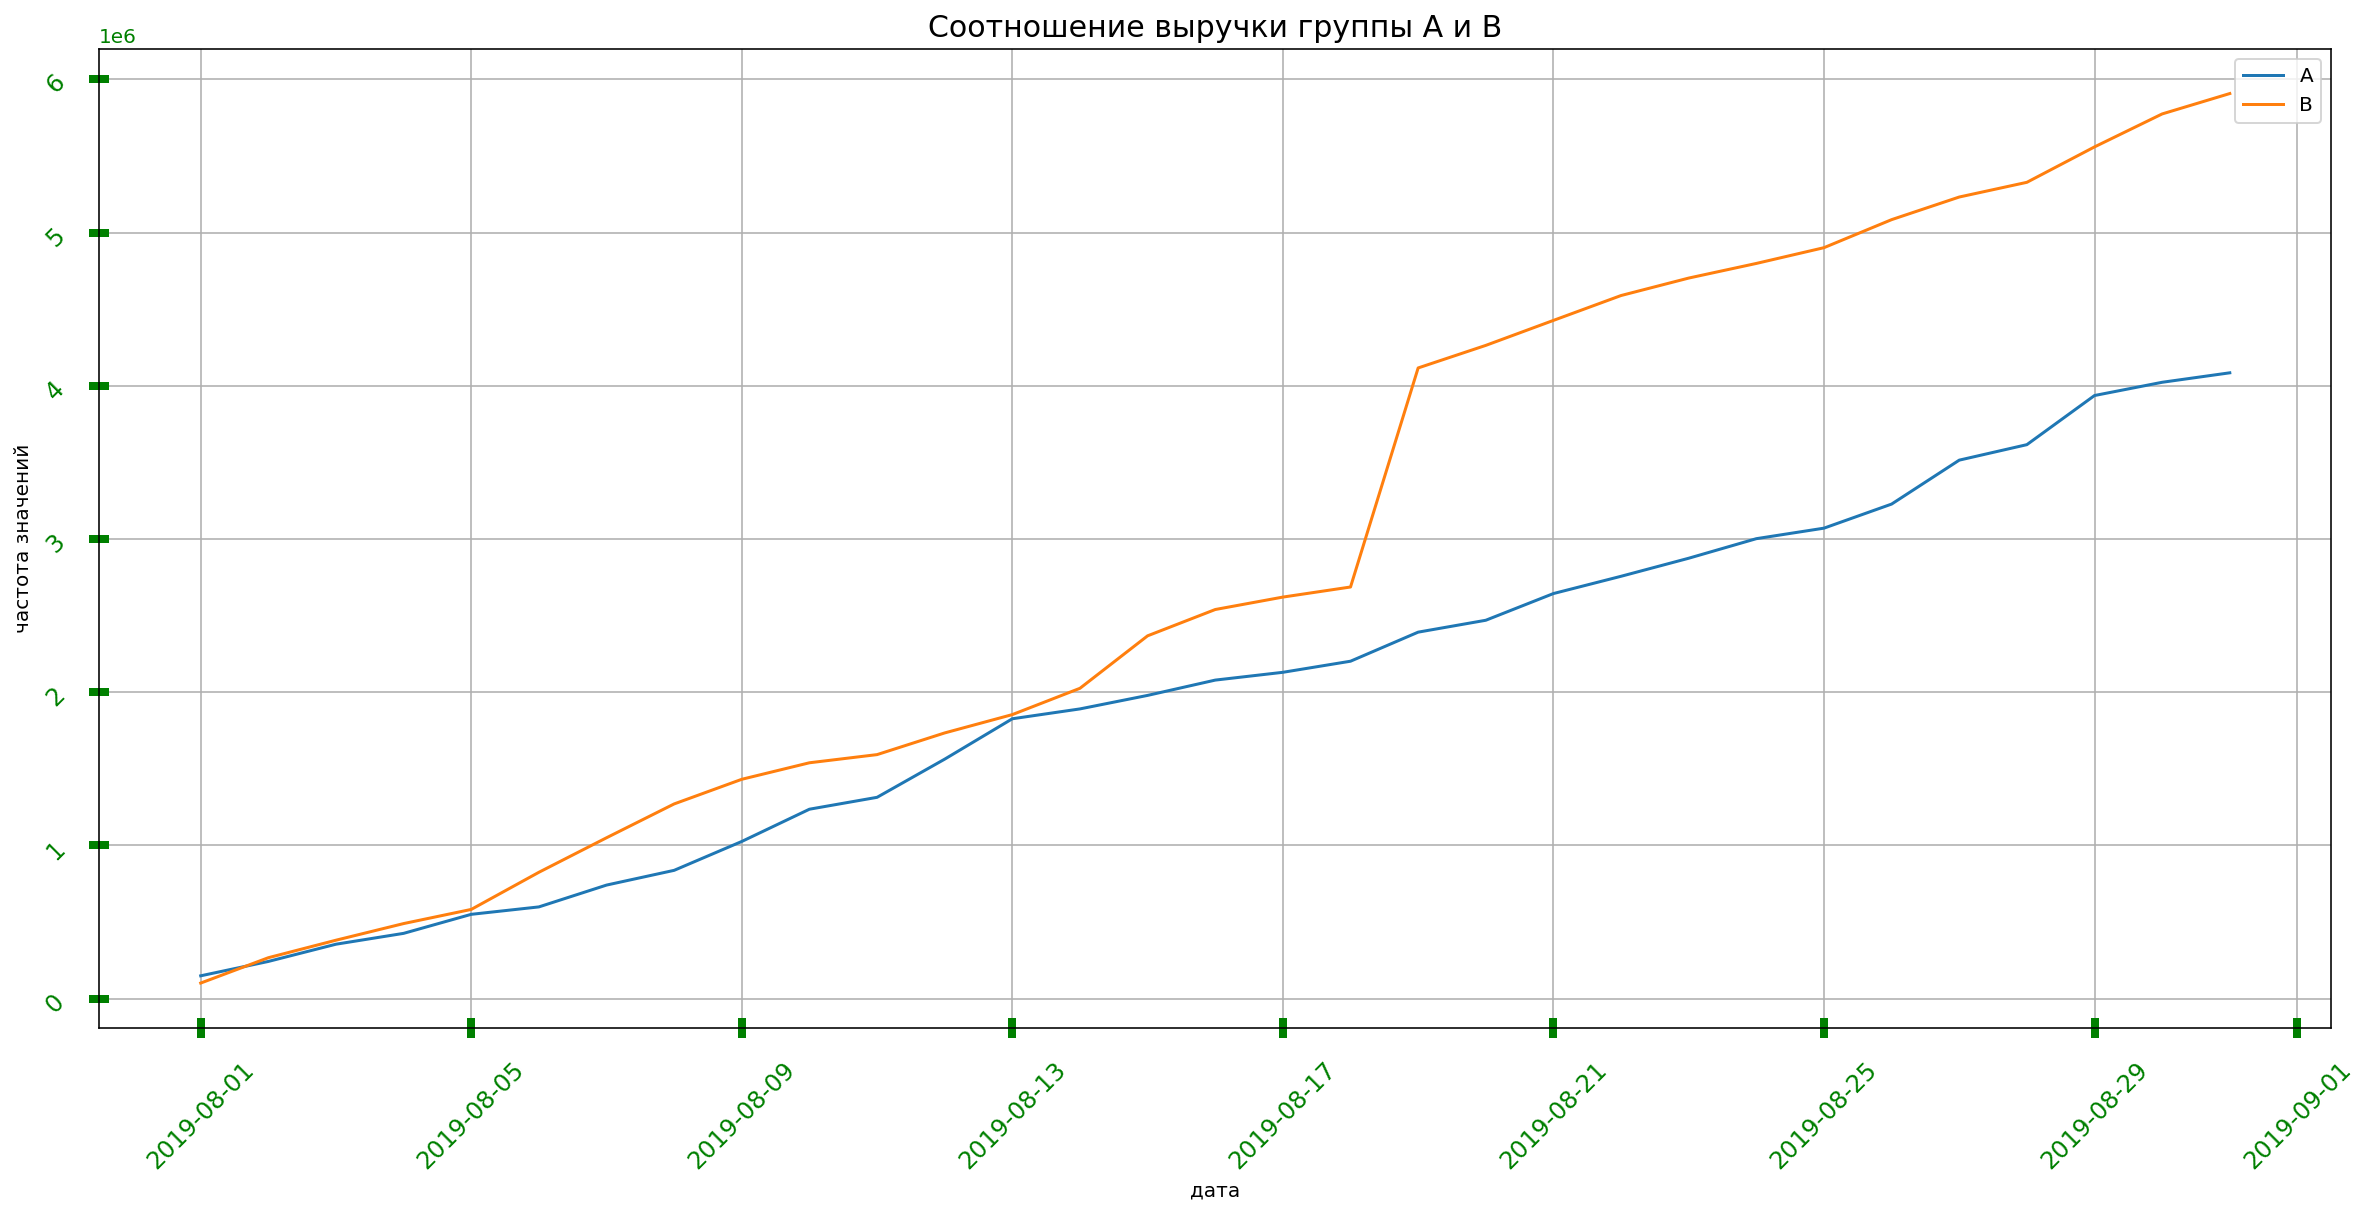

In [ ]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]
plt.figure(figsize=(20,9))
plt.title('Соотношение выручки группы А и В', fontsize = 15)
plt.xlabel('дата')
plt.ylabel('частота значений')
# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')
# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.tick_params(axis = 'both',    #  Применяем параметры к обеим осям
               which = 'major',    #  Применяем параметры к основным делениям
               direction = 'inout',    #  Рисуем деления внутри и снаружи графика
               length = 10,    #  Длинна делений
               width = 4,     #  Ширина делений
               color = 'g',    #  Цвет делений
               pad = 10,    #  Расстояние между черточкой и ее подписью
               labelsize = 12,    #  Размер подписи
               labelcolor = 'g',    #  Цвет подписи
            rotation= 45 )    #  Поворот подписей
plt.grid()
plt.legend()
plt.show()

Выручка почти равномерно увеличивается в течение всего теста. Однако графики выручки группы В резко возрастает в перио с 17 по 21 число. Это может сигнализировать о всплесках числа заказов, либо о появлении очень дорогих заказов в выборке.

### Построим график кумулятивного среднего чека по группам.

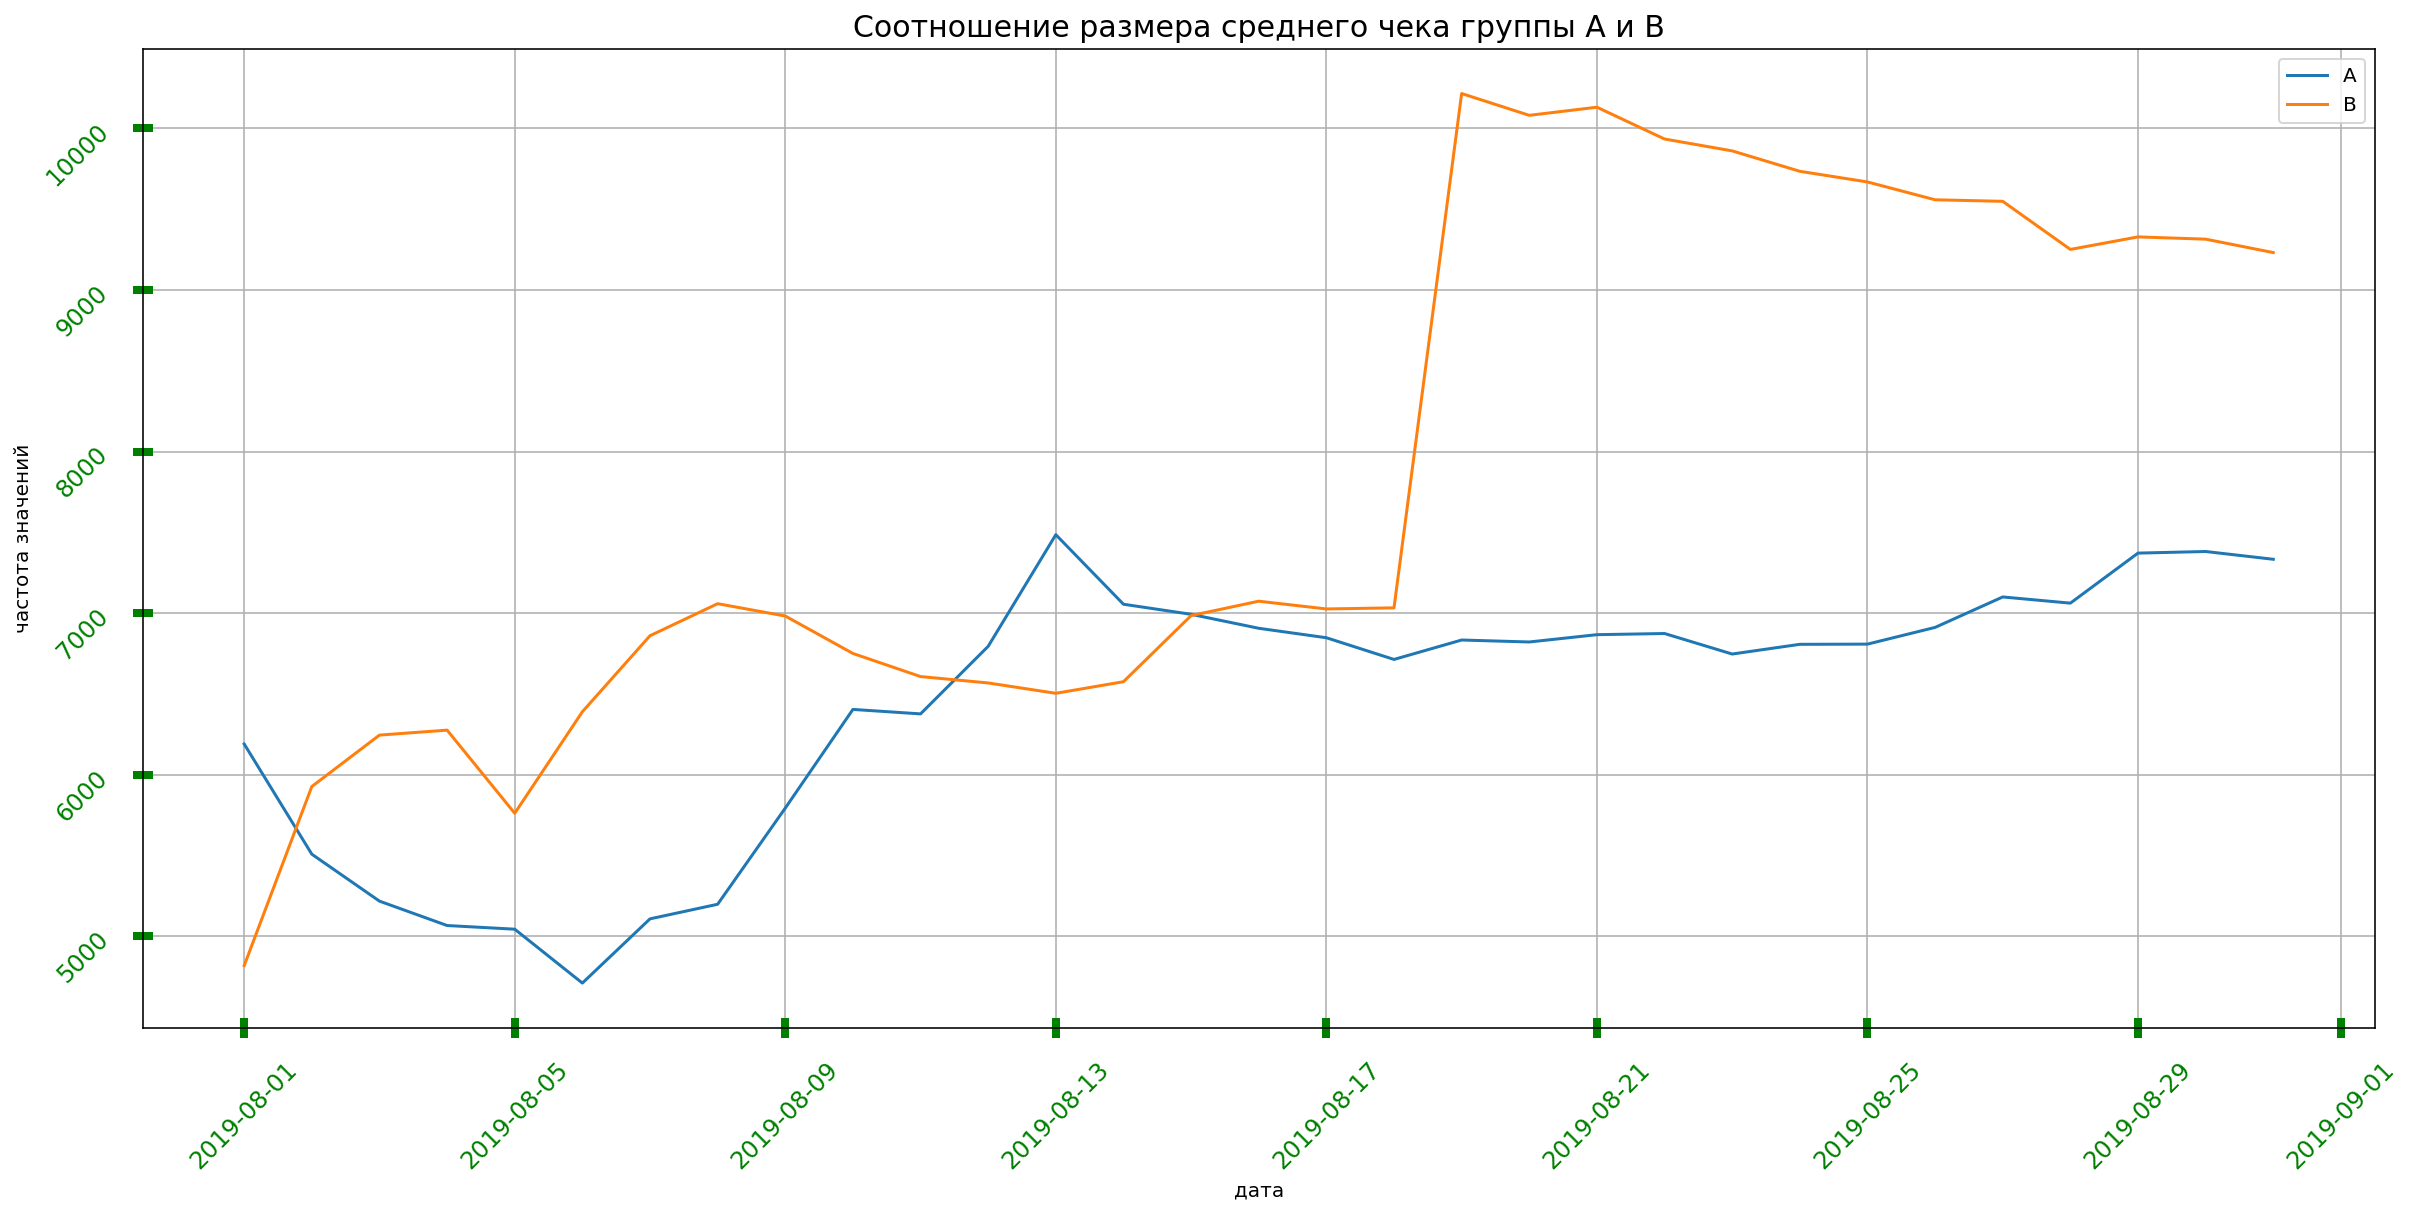

In [ ]:
plt.figure(figsize=(20,9))
plt.title('Соотношение размера среднего чека группы А и В', fontsize = 15)
plt.xlabel('дата')
plt.ylabel('частота значений')
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.tick_params(axis = 'both',    #  Применяем параметры к обеим осям
               which = 'major',    #  Применяем параметры к основным делениям
               direction = 'inout',    #  Рисуем деления внутри и снаружи графика
               length = 10,    #  Длинна делений
               width = 4,     #  Ширина делений
               color = 'g',    #  Цвет делений
               pad = 10,    #  Расстояние между черточкой и ее подписью
               labelsize = 12,    #  Размер подписи
               labelcolor = 'g',    #  Цвет подписи
            rotation= 45 )    #  Поворот подписей
plt.grid()
plt.legend()
plt.show()


Средний чек тоже становится равномерным ближе к концу теста: установился для группы A и продолжает падать для группы B. Возможно, в группу B в период с 17 по 21 число попали крупные заказы (резкий всплеск на графике). Тогда нужно больше данных, чтобы прийти к реальному среднему чеку и установиться на его уровне. На дистанции значение должны устаканиться, примерно это и показывает группа A. На группу B же сильно повлиял скачок

### Построим график относительного изменения кумулятивного среднего чека группы B к группе A. 

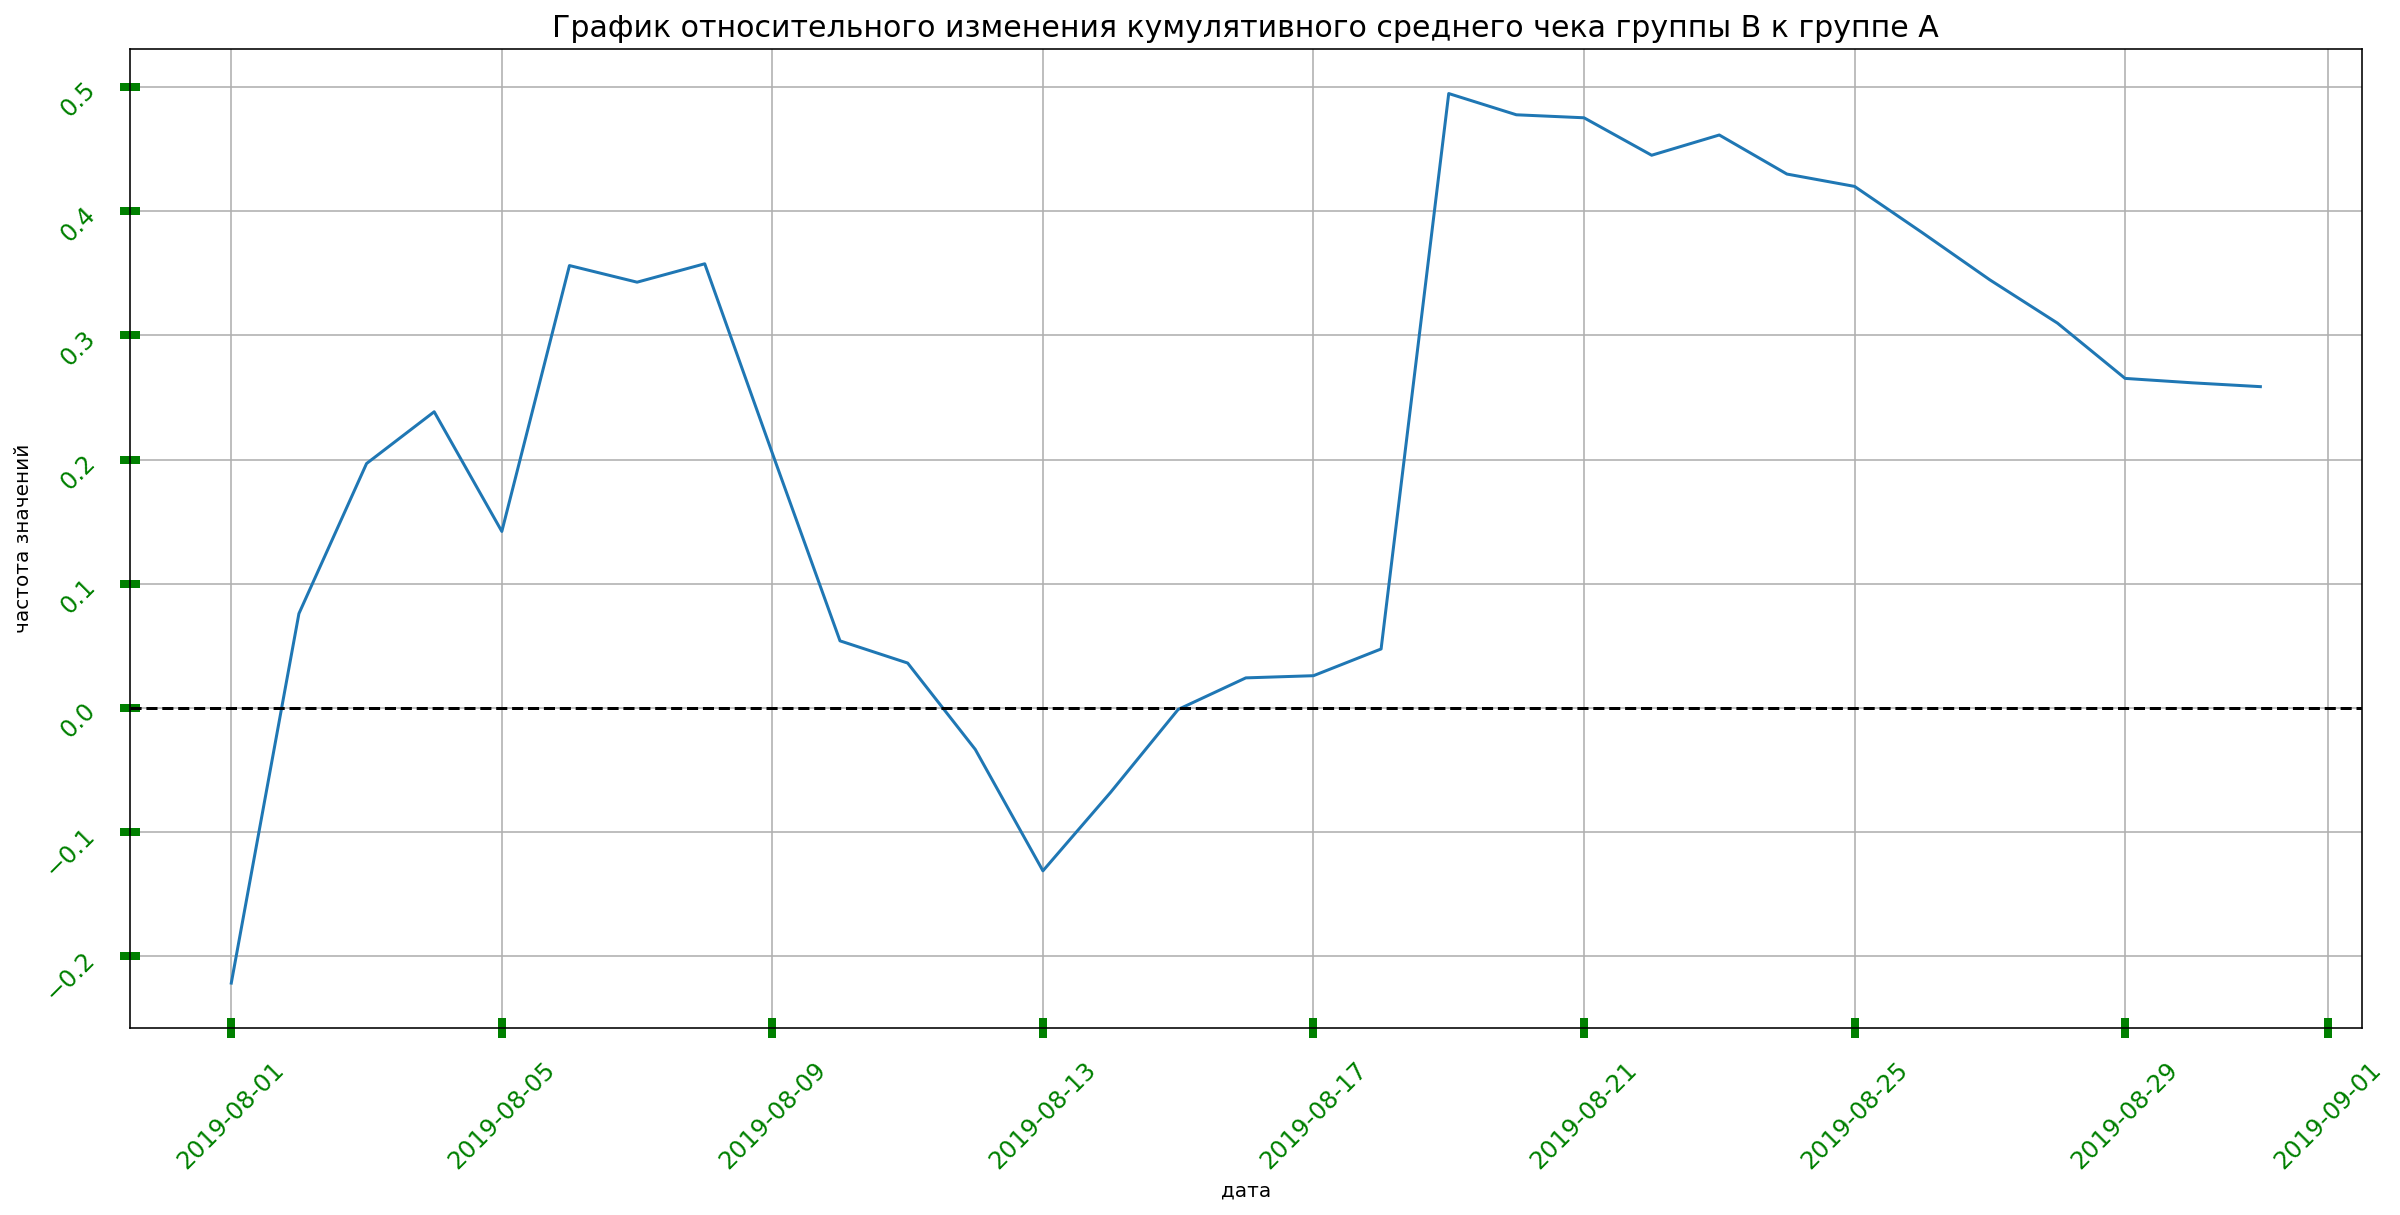

In [ ]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
plt.figure(figsize=(20,9))
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A', fontsize = 15)
plt.xlabel('дата')
plt.ylabel('частота значений')
# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)
# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')
plt.tick_params(axis = 'both',    #  Применяем параметры к обеим осям
               which = 'major',    #  Применяем параметры к основным делениям
               direction = 'inout',    #  Рисуем деления внутри и снаружи графика
               length = 10,    #  Длинна делений
               width = 4,     #  Ширина делений
               color = 'g',    #  Цвет делений
               pad = 10,    #  Расстояние между черточкой и ее подписью
               labelsize = 12,    #  Размер подписи
               labelcolor = 'g',    #  Цвет подписи
            rotation= 45 )    #  Поворот подписей
plt.grid()
plt.show()


В нескольких точках график различия между сегментами резко «скачет». В период с 17 по 21 число точно спрятались крупные заказы и выбросы! 

### Построим график кумулятивной конверсии по группам. 

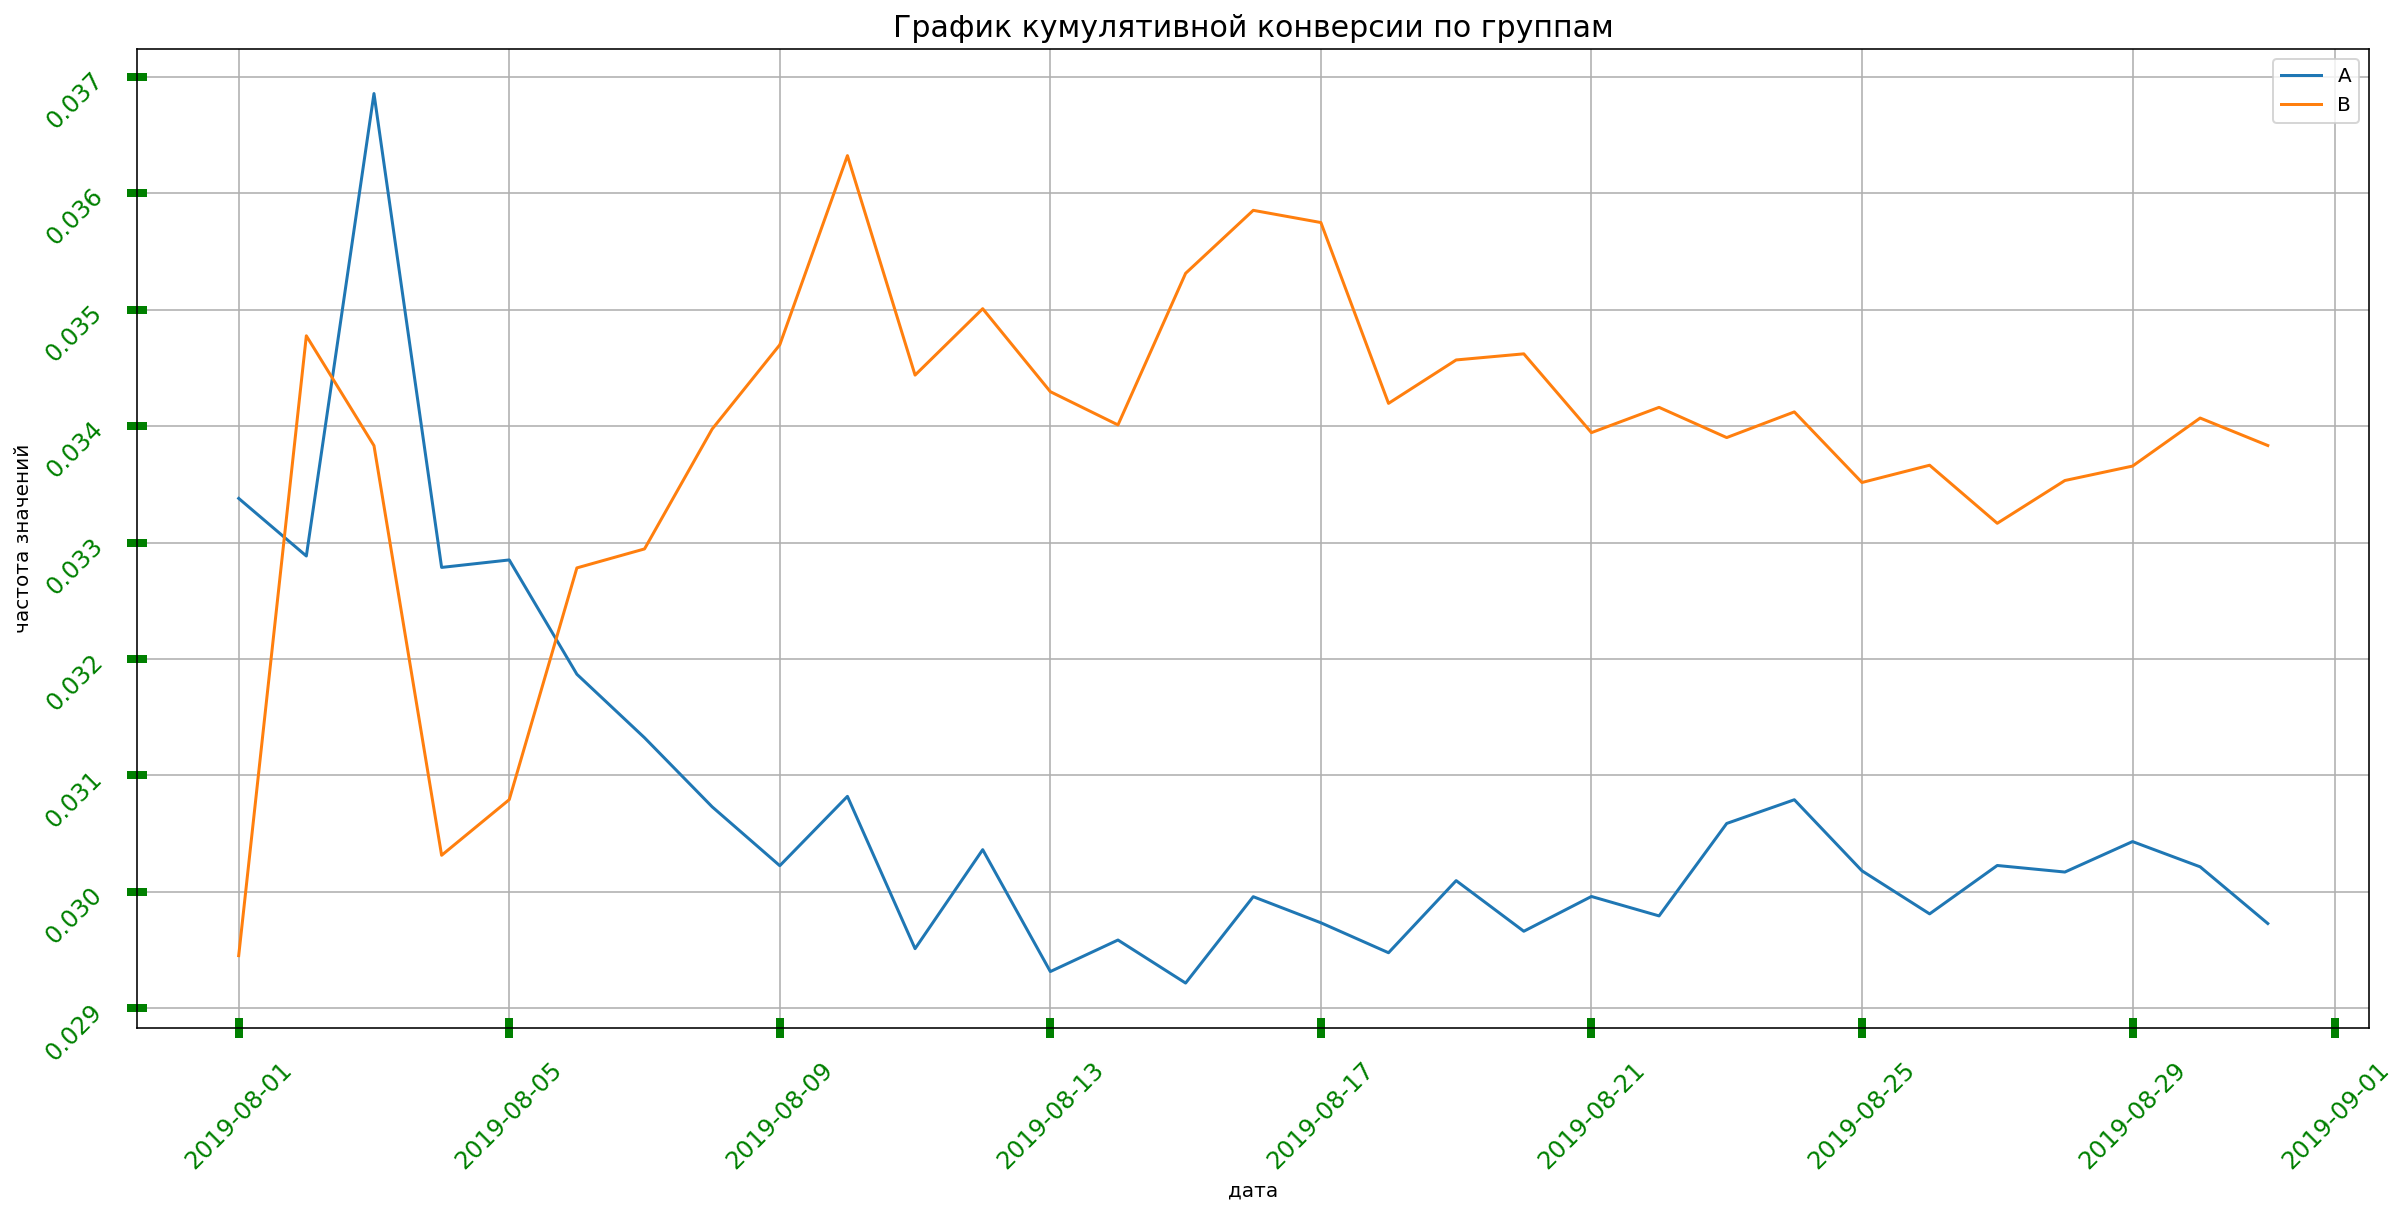

In [ ]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']
# строим графики
plt.figure(figsize=(20,9))
plt.title('График кумулятивной конверсии по группам', fontsize = 15)
plt.xlabel('дата')
plt.ylabel('частота значений')
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()
# задаем масштаб осей
#plt.axis(['2019-08-01', '2019-08-31', 0, 0.05])
plt.tick_params(axis = 'both',    #  Применяем параметры к обеим осям
               which = 'major',    #  Применяем параметры к основным делениям
               direction = 'inout',    #  Рисуем деления внутри и снаружи графика
               length = 10,    #  Длинна делений
               width = 4,     #  Ширина делений
               color = 'g',    #  Цвет делений
               pad = 10,    #  Расстояние между черточкой и ее подписью
               labelsize = 12,    #  Размер подписи
               labelcolor = 'g',    #  Цвет подписи
            rotation= 45 )    #  Поворот подписей
plt.grid()
plt.show()

Группы колебались около одного значения, но затем конверсия группы В вырвалась вперёд и зафиксировалась, а конверсия группы А просела и также зафиксировалась.

### Постройте график относительного изменения кумулятивной конверсии группы B к группе A. Сделайте выводы и предположения.

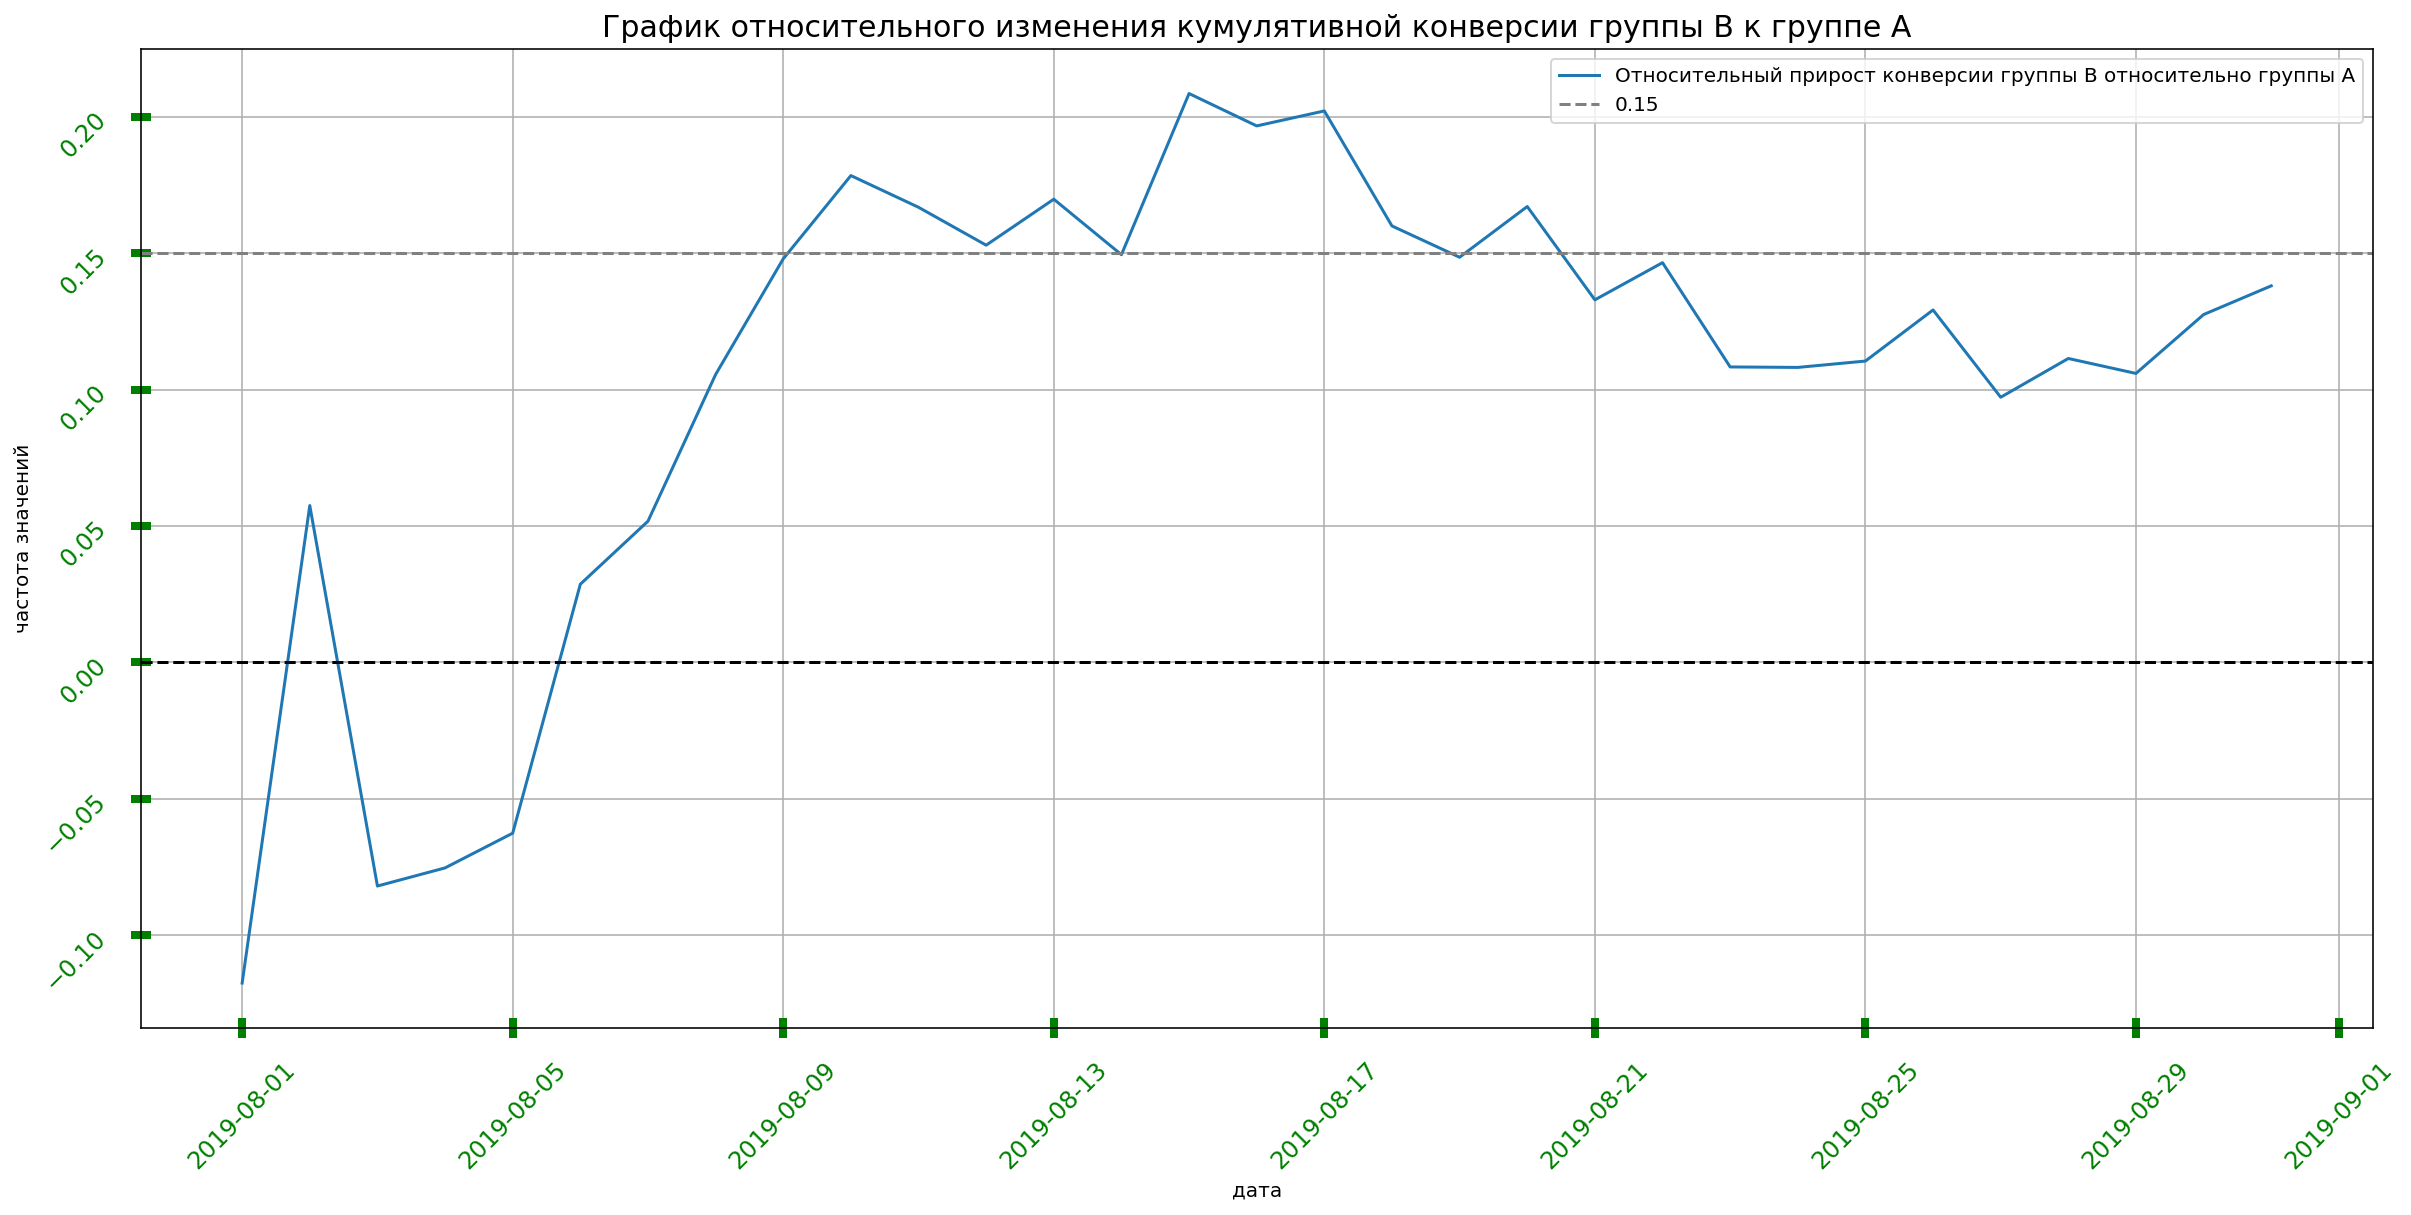

In [ ]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
plt.figure(figsize=(20,9))
plt.title('График относительного изменения кумулятивной конверсии группы B к группе A', fontsize = 15)
plt.xlabel('дата')
plt.ylabel('частота значений')
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y= 0.15, color='grey', linestyle='--', label = '0.15')
#plt.axis(["2019-08-01", '2019-08-31', -0.5, 0.5])
plt.tick_params(axis = 'both',    #  Применяем параметры к обеим осям
               which = 'major',    #  Применяем параметры к основным делениям
               direction = 'inout',    #  Рисуем деления внутри и снаружи графика
               length = 10,    #  Длинна делений
               width = 4,     #  Ширина делений
               color = 'g',    #  Цвет делений
               pad = 10,    #  Расстояние между черточкой и ее подписью
               labelsize = 12,    #  Размер подписи
               labelcolor = 'g',    #  Цвет подписи
            rotation= 45 )    #  Поворот подписей
plt.legend()
plt.grid()
plt.show()

В начале теста группа B выигрывала у группы A, далее резкое падение, но затем группа B  стабильно и постепенно растёт с небольшими колебаниями.
В целом отношение конверсии ещё не установилось, и сейчас делать какие-либо выводы по тесту нельзя. Впрочем, сперва стоит проанализировать аномалии, возможно, они изменят картину.

### Построим точечный график количества заказов по пользователям. 

   transactionId   visitorId       date  revenue group
0     3667963787  3312258926 2019-08-15     1650     B
1     2804400009  3642806036 2019-08-15      730     B
2     2961555356  4069496402 2019-08-15      400     A
3     3797467345  1196621759 2019-08-15     9759     B
4     2282983706  2322279887 2019-08-15     2308     B


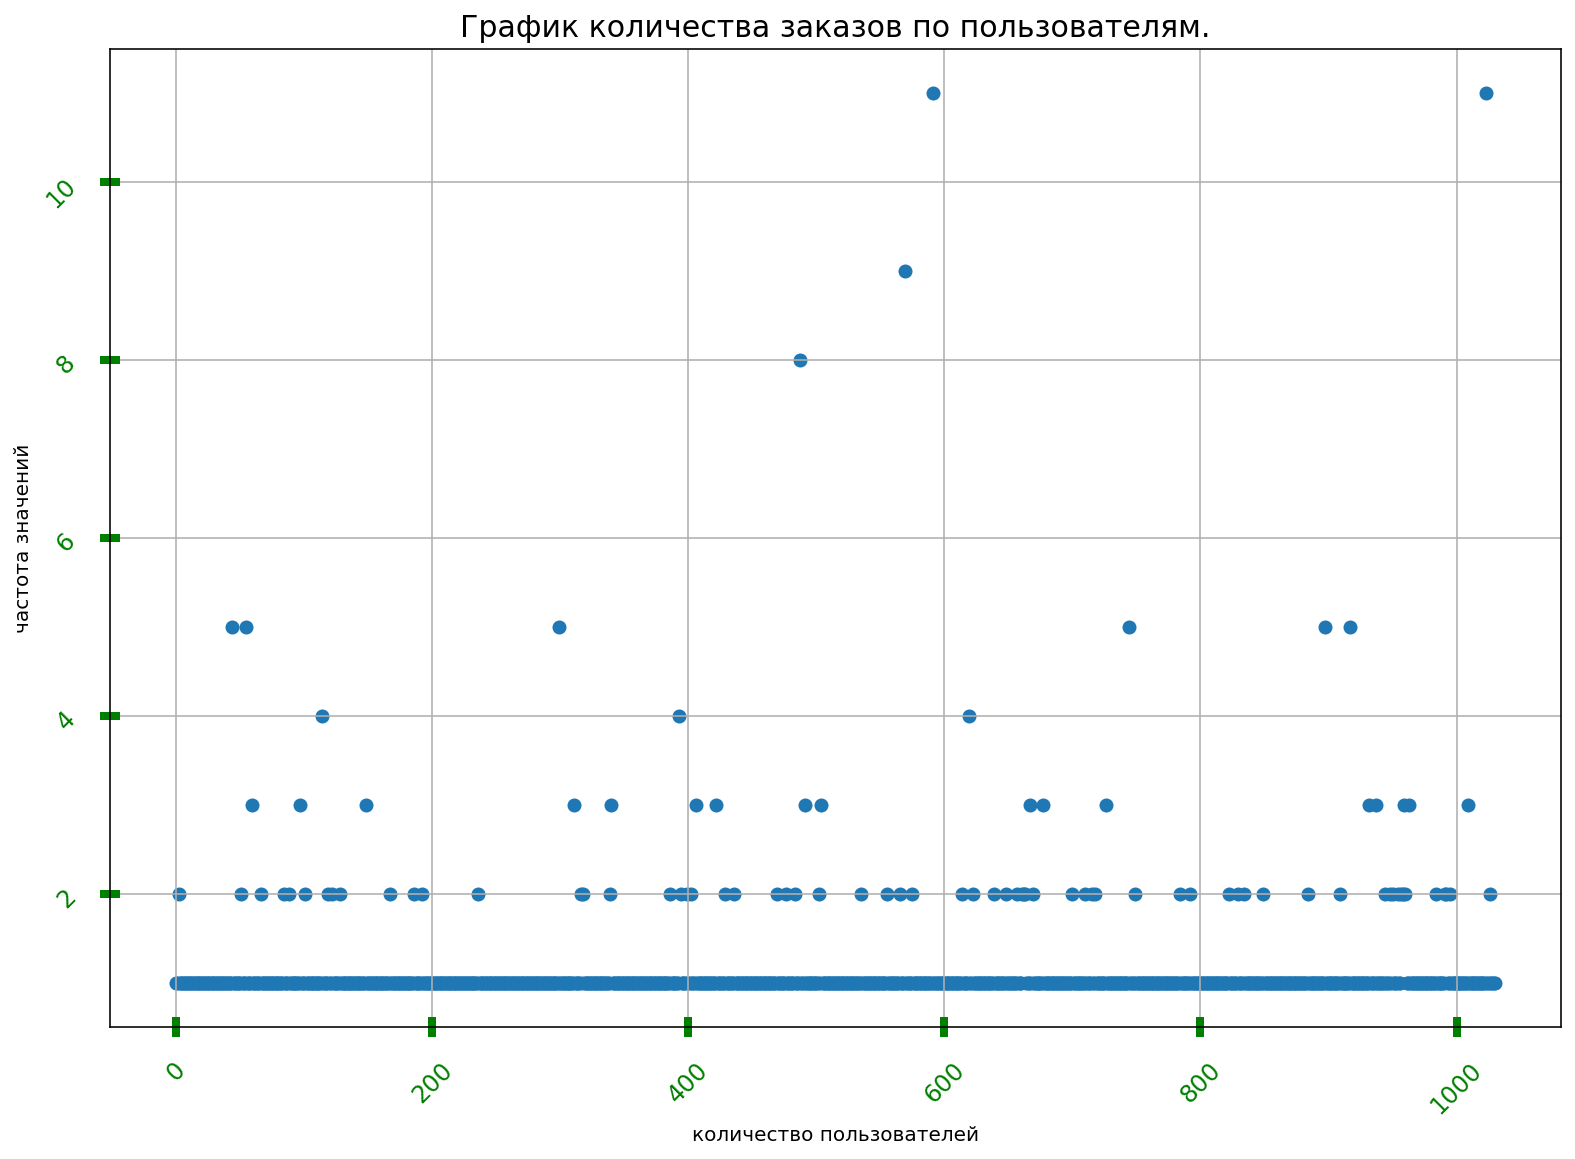

In [ ]:
print(orders.head(5))
ordersByUsers = (
    orders.drop(['group', 'revenue', 'date'], axis=1)
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)

ordersByUsers.columns = ['visitorId', 'orders']
ordersByUsers.sort_values(by='orders', ascending=False).head(10)
x_values = pd.Series(range(0,len(ordersByUsers)))
plt.figure(figsize=(13,9))
plt.title('График количества заказов по пользователям.', fontsize = 15)
plt.xlabel('количество пользователей')
plt.ylabel('частота значений')
plt.scatter(x_values, ordersByUsers['orders'])
plt.tick_params(axis = 'both',    #  Применяем параметры к обеим осям
               which = 'major',    #  Применяем параметры к основным делениям
               direction = 'inout',    #  Рисуем деления внутри и снаружи графика
               length = 10,    #  Длинна делений
               width = 4,     #  Ширина делений
               color = 'g',    #  Цвет делений
               pad = 10,    #  Расстояние между черточкой и ее подписью
               labelsize = 12,    #  Размер подписи
               labelcolor = 'g',    #  Цвет подписи
            rotation= 45 )    #  Поворот подписей
plt.grid()
plt.show()

Большинство покупателей заказывали только один раз. Однако доля пользователей с 2-4 заказами тоже значительна. Их точная доля не ясна. Непонятно, считать их аномалиями или нет. Принято отсеивать от 1% до 5% наблюдений с крайними значениями. Посчитаем выборочные перцентили количества заказов на одного пользователя:

### Посчитаем 95-й и 99-й перцентили количества заказов на пользователя. Выберем границу для определения аномальных пользователей.

In [ ]:
print(np.percentile(ordersByUsers['orders'], [95, 99])) 

[2. 4.]


Не более 5% пользователей оформляли больше чем 2 заказа. Разумно выбрать 2 заказа на одного пользователя за нижнюю границу числа заказов, и отсеять аномальных пользователей по ней. Удалением таких строк рассмотрим далее.

### Построим точечный график стоимостей заказов. 

      transactionId   visitorId       date  revenue group
425       590470918  1920142716 2019-08-19  1294500     B
1196     3936777065  2108080724 2019-08-15   202740     B
858       192721366  1316129916 2019-08-27    93940     A
1136      666610489  1307669133 2019-08-13    92550     A
744      3668308183   888512513 2019-08-27    86620     B
682      1216533772  4266935830 2019-08-29    78990     B
662      1811671147  4266935830 2019-08-29    78990     A
743      3603576309  4133034833 2019-08-09    67990     A
1103     1348774318  1164614297 2019-08-12    66350     A
1099      316924019   148427295 2019-08-12    65710     A


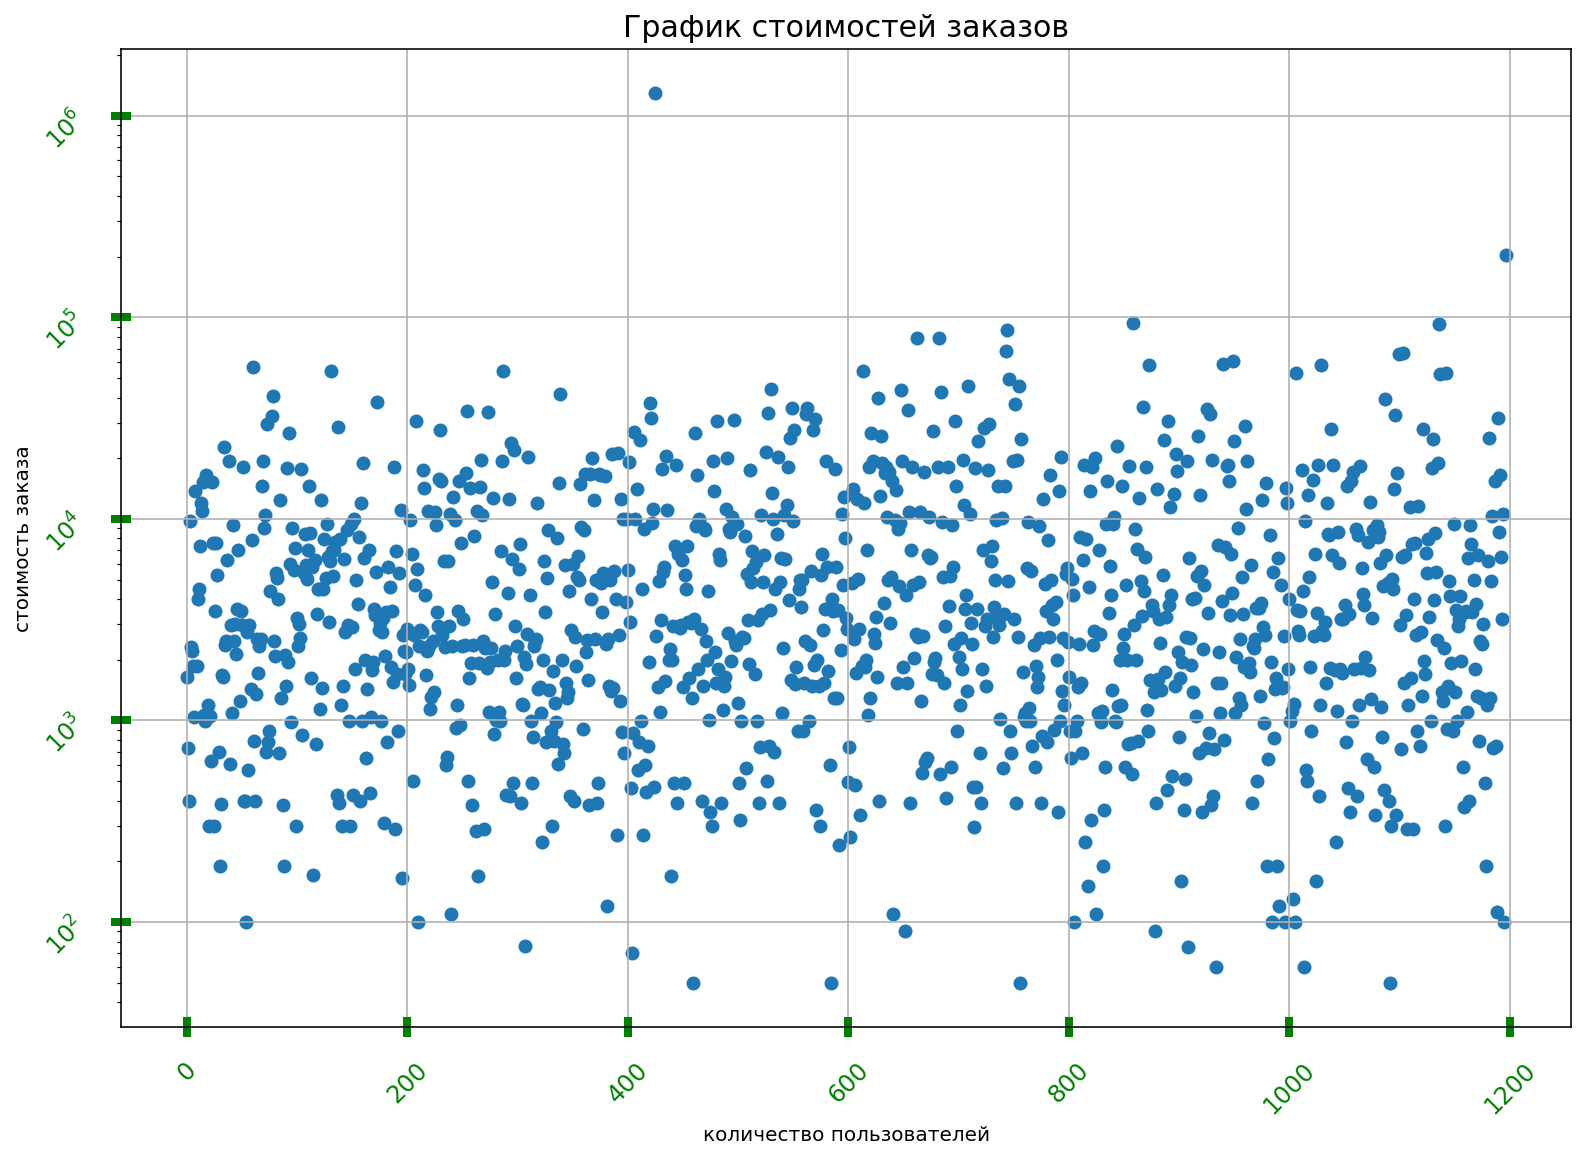

In [ ]:
print(orders.sort_values(by='revenue', ascending=False).head(10))
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.figure(figsize=(13,9))
plt.title('График стоимостей заказов', fontsize = 15)
plt.xlabel('количество пользователей')
plt.ylabel('стоимость заказа')
plt.scatter(x_values, orders['revenue']) 
plt.tick_params(axis = 'both',    #  Применяем параметры к обеим осям
               which = 'major',    #  Применяем параметры к основным делениям
               direction = 'inout',    #  Рисуем деления внутри и снаружи графика
               length = 10,    #  Длинна делений
               width = 4,     #  Ширина делений
               color = 'g',    #  Цвет делений
               pad = 10,    #  Расстояние между черточкой и ее подписью
               labelsize = 12,    #  Размер подписи
               labelcolor = 'g',    #  Цвет подписи
            rotation= 45 )    #  Поворот подписей
#plt.axis([0, 1210, 0, 200000])
plt.semilogy() 
plt.grid()
plt.show()

Всё, как предполагали: есть аномально дорогие заказы. 1 294 500, вот почему так резко поднялся средний чек. По графику нельзя выбрать границу аномальных заказов. Обратимся к процентилям. Детализировали график за счёт логарифмической оси. Теперь хорош различимы все части графика.

### Посчитаем 95-й и 99-й перцентили стоимости заказов. Выберем границу для определения аномальных заказов.

In [ ]:
print(np.percentile(orders['revenue'], [95, 99])) 

[28000.  58233.2]


Не более 5% заказов дороже 28000 рублей и не более 1% дороже 58233 рублей. Тут очень сложно выбрать, по графику мы видим очень маленький разброс точек. Можно выбрать нижнее занчение 58233. Но я все таки выберу 28000. 

###  Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. 

Подготовим данные

In [ ]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

data.head(5)

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280


Посчитаем статистическую значимость различия в среднем чеке между группами.

In [ ]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitorId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitorId', 'orders']

sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

In [ ]:
alpha = 0.05
statavercheck = format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1])
print('{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('p-значение:', round(float(statavercheck), 3))
if float(statavercheck) < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")
      
print('Относительный средний чек группы A меньше группы В на {0:.3%}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)) 

0.365
p-значение: 0.365
Не получилось отвергнуть нулевую гипотезу
Относительный средний чек группы A меньше группы В на 25.871%


Примем P-value = 0,05, так как нет необходимости в высокой точности. Сформулируем Н0 - Размеры средних чеков в группах А и Б одинаковые. Н1 - Размеры средних чеков в группах А и Б различны.

P-value значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. Впрочем, средний чек группы А значительно ниже среднего чека группы В.
Чтобы рассчитать статистическую значимость различий в конверсии между сегментами, передадим критерию mannwhitneyu() данные о количествах заказов и посетителей.

### Посчитаем статистическую значимость различий в конверсии между группами по «сырым» данным. 

In [ ]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitorId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitorId', 'orders']

sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)


sampleA, sampleB готовы. Посчитаем статистическую значимость различия в конверсии между группами.

In [ ]:

alpha = 0.05
stat_conver = format(stats.mannwhitneyu(sampleA, sampleB)[1])
print('{0:.3f}'.format(stats.mannwhitneyu(sampleA, sampleB)[1]))
print('p-значение:', round(float(stat_conver), 3))
if float(stat_conver) < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")
      
print('Относительный конверсия группы В больше группы А на {0:.3%}'.format(sampleB.mean() / sampleA.mean() - 1)) 

0.008
p-значение: 0.008
Отвергаем нулевую гипотезу
Относительный конверсия группы В больше группы А на 13.808%


Примем P-value = 0,05, так как нет необходимости в высокой точности. Сформулируем Н0 - Конверсии в группах А и Б одинаковые. Н1 - Конверсии в группах А и Б различны.

P-value значительно меньше 0.05. Значит, есть причины отвергнуть нулевую гипотезу и считать, что в конверсии есть различия Конверсия группы В больше группы А на 13,8 %.

Напомним, что найденные ранее 95-й и 99-й перцентили средних чеков равны 28000 и 58233.2 рублям. А 95-й и 99-й перцентили количества заказов на одного пользователя равны 2 и 4 заказа на пользователя.
Примем за аномальных пользователей тех, кто совершил от 3 заказов или совершил заказ дороже 28 000 рублей. Так мы уберём 5% пользователей с наибольшим числом заказов и от 5% пользователей с дорогими заказами. 

### Посчитаем статистическую значимость различий в конверсии между группами по «очищенным» данным. 

Сделаем срезы пользователей с числом заказов больше 2  и пользователей, совершивших заказы дороже 28 000.

In [ ]:
norm_orders = 2
norm_price = 28000


usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > norm_orders]['visitorId'],
        ordersByUsersB[ordersByUsersB['orders'] > norm_orders]['visitorId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > norm_price]['visitorId']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormalUsers.head(5))
print(abnormalUsers.shape) 

1099    148427295
18      199603092
928     204675465
23      237748145
37      249864742
Name: visitorId, dtype: int64
(74,)


74 аномальных пользователя.

Сформируем выборки и посчитаем статистическую значимость в конверсии.

In [ ]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['visitorId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['visitorId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
) 

In [ ]:
alpha = 0.05
pv3 = format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1])
print('{0:.3f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('p-значение:', round(float(pv3), 3))
if float(pv3) < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")
      
print('Относительный конверсия группы В больше группы А на {0:.3%}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 

0.007
p-значение: 0.007
Отвергаем нулевую гипотезу
Относительный конверсия группы В больше группы А на 17.270%


Сформулируем Н0 - Конверсии в группах А и Б одинаковые. Н1 - Конверсии в группах А и Б различны. P-value значительно меньше 0.05. Значит, есть причины отвергнуть нулевую гипотезу и считать, что в конверсии есть различия. Гипотеза подтвердилась? Конверсия группы В больше группы А на 17,27 %.

### Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. Сделайте выводы и предположения.

In [ ]:
print(
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
) 

0.369
-0.020


Сформулируем Н0 - Размер среднего чека в группах А и Б одинаковые. Н1 - Размер среднего чека в группах А и Б различны. P-value значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. Впрочем, средний чек группы А незначительно выше (на 2%) среднего чека группы В.

### Примем решение по результатам теста и объясним его. 

P-value в среднем чеке и конверсии практически не изменился, но изменилась разница в среднем чеке с 25% до -2%.
Какие выводы по тесту можем сделать?
Имеющиеся факты:
Есть статистически значимые различия по конверсии между группами и по «сырым», и по данным после фильтрации аномалий;
Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий;
График различия конверсии между группами сообщает, что результаты группы B лучше группы A и нет значительной тенденции к ухудшению:

График различия среднего чека говорит о том, что результаты группы B лучше группы А на 25%: Но при отстутсвии анамалий мы видим незначительное снижение на 2%. Для принятия решения предлагаю построить график различия среднего чека без аномалий.



In [ ]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1197 non-null   int64         
 1   visitorId      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   int64         
 4   group          1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


In [ ]:
orders_f = orders.copy()
orders_f = orders_f.query('revenue < 28000')
orders_f.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1137 entries, 0 to 1195
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1137 non-null   int64         
 1   visitorId      1137 non-null   int64         
 2   date           1137 non-null   datetime64[ns]
 3   revenue        1137 non-null   int64         
 4   group          1137 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 53.3+ KB


Исключили 60 заказов.

In [ ]:
datesGroups = orders_f[['date','group']].drop_duplicates() 
ordersAggregated = datesGroups.apply(lambda x: orders_f[np.logical_and(orders_f['date'] <= x['date'], orders_f['group'] == x['group'])]\
.agg({'date' : 'max', 'group' : 'max', 'transactionId' : pd.Series.nunique, 'visitorId' : pd.Series.nunique, 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]


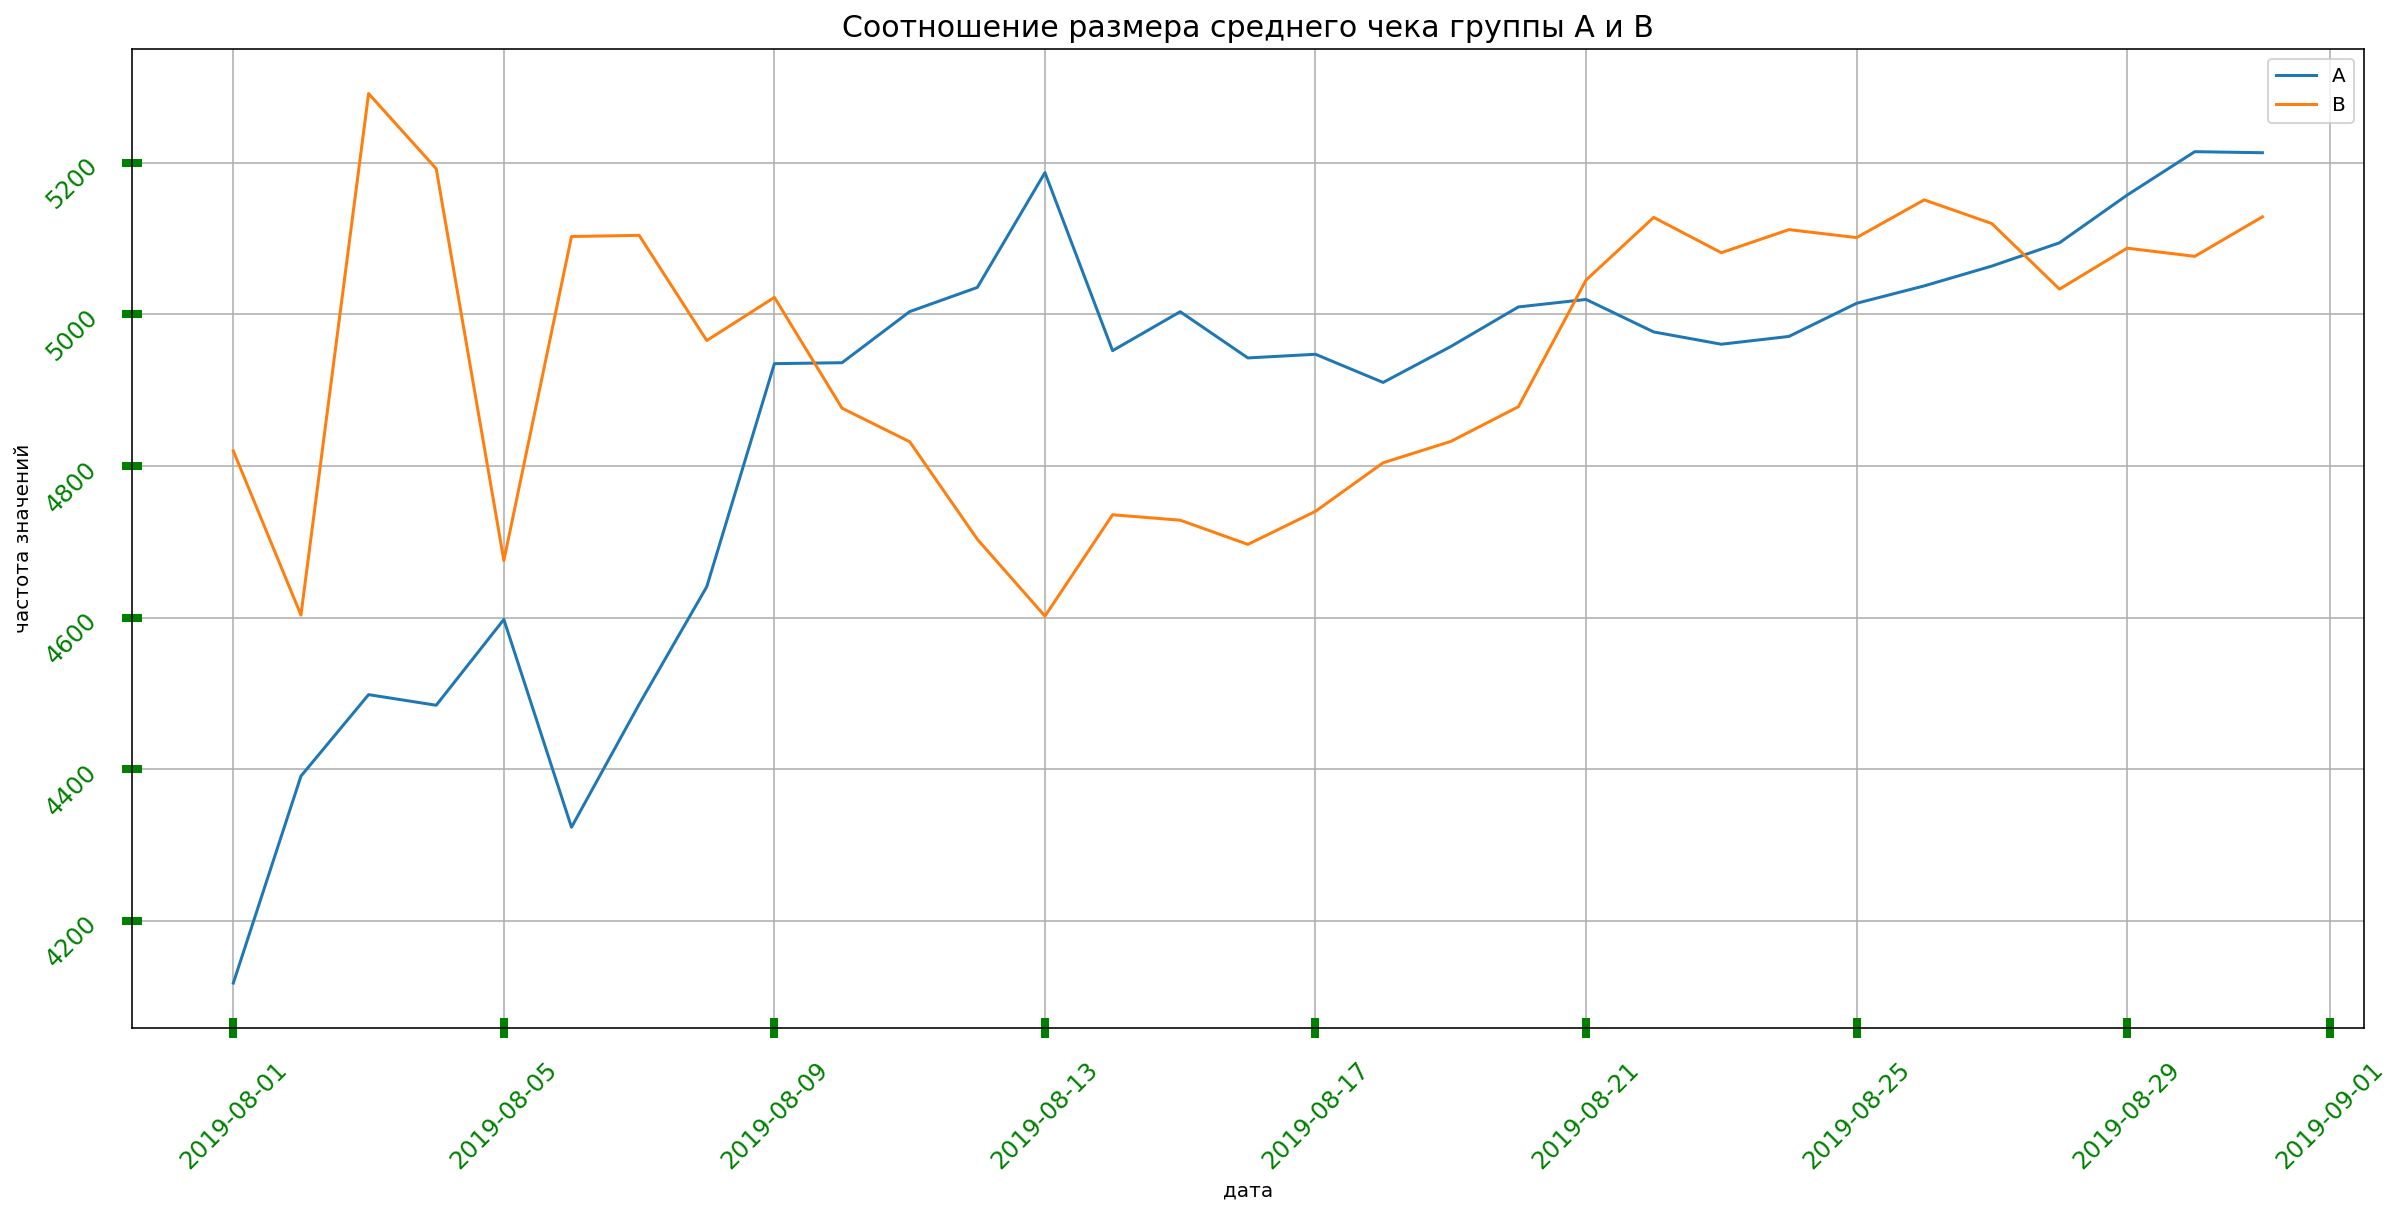

In [ ]:
plt.figure(figsize=(20,9))
plt.title('Соотношение размера среднего чека группы А и В', fontsize = 15)
plt.xlabel('дата')
plt.ylabel('частота значений')
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.tick_params(axis = 'both',    #  Применяем параметры к обеим осям
               which = 'major',    #  Применяем параметры к основным делениям
               direction = 'inout',    #  Рисуем деления внутри и снаружи графика
               length = 10,    #  Длинна делений
               width = 4,     #  Ширина делений
               color = 'g',    #  Цвет делений
               pad = 10,    #  Расстояние между черточкой и ее подписью
               labelsize = 12,    #  Размер подписи
               labelcolor = 'g',    #  Цвет подписи
            rotation= 45 )    #  Поворот подписей
plt.grid()
plt.legend()
plt.show()


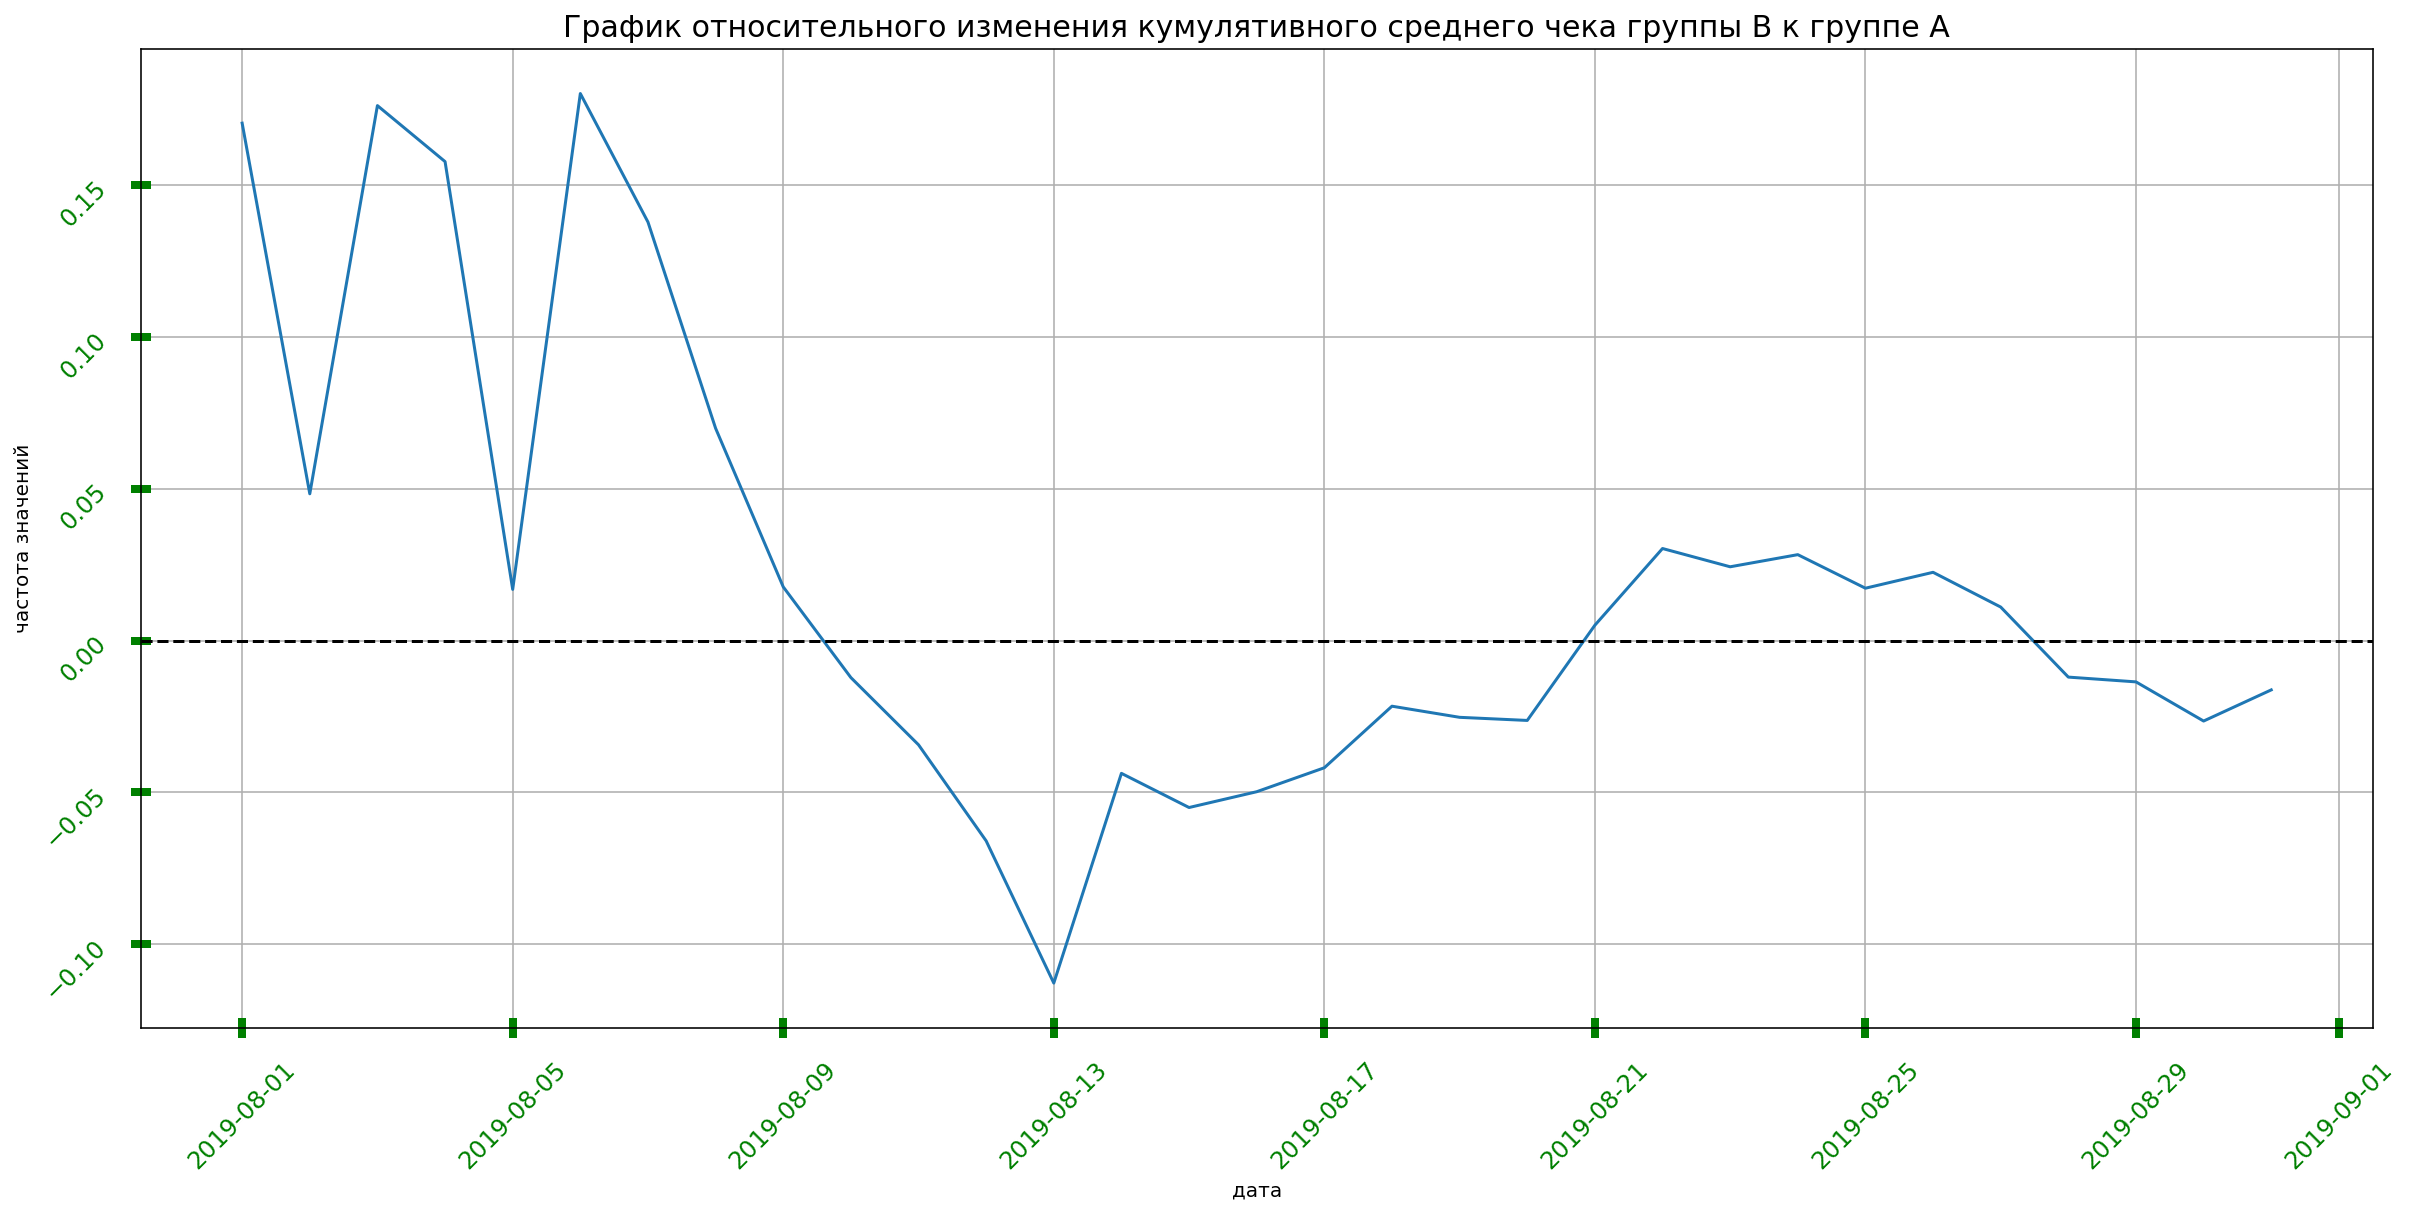

In [ ]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
plt.figure(figsize=(20,9))
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A', fontsize = 15)
plt.xlabel('дата')
plt.ylabel('частота значений')
# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)
# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')
plt.tick_params(axis = 'both',    #  Применяем параметры к обеим осям
               which = 'major',    #  Применяем параметры к основным делениям
               direction = 'inout',    #  Рисуем деления внутри и снаружи графика
               length = 10,    #  Длинна делений
               width = 4,     #  Ширина делений
               color = 'g',    #  Цвет делений
               pad = 10,    #  Расстояние между черточкой и ее подписью
               labelsize = 12,    #  Размер подписи
               labelcolor = 'g',    #  Цвет подписи
            rotation= 45 )    #  Поворот подписей
plt.grid()
plt.show()

Мы видим данные по среднему чеку еще не "устаканились". Если нам важен этот показатель, то тест следует продолжнить. Если нас больше интересует только конверсия, то тест можно прекращать, гипотеза об увеличении конверсии на 17 % подтвердилась. Предположу, что нам важны оба показателя, следовательно тест следует продолжить. С другой стононы у нас P-value среднего чека значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. Не важно на сколько средний чек больше или меньше - это статистически не значимо.  
* Вывод: Остановить тест, зафиксировать победу группы B. После внедрения гипотезы конверсия увеличилась на 17%, средний чек не изменился. 

## Общий вывод

Была проделана большая работа. Мы проверили данные в таблице и привели их к нужно типу. Мы применили фреймворк для выбора наиболее подходящей гипотезы - Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок. Данная гипотеза будет иметь максимальный охват, повлияет на пользователей достаточно сильно, и задействует не много трудозатрат. Мы агрегировали данные для проведения А/Б теста. Построили графики кумулятивной выручки, среднего чека и относительно изминения конверсии. Выявили аномалии и исключили их по 95 процентилю. Затем подготовили выборки и посчитали статистичискую значимость изминений конверсии и размера среднего чека с аномалиями и без. По результатам проделанной работы можно сделать вывод:
* Что есть статистически значимые различия по конверсии между группами и по «сырым», и по данным после фильтрации аномалий;
* Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий;
* График различия конверсии между группами сообщает, что результаты группы B лучше группы A и нет значительной тенденции к ухудшению.
* График различия среднего чека говорит о том, что результаты группы B лучше группы А на 25%: Но при отстутсвии анамалий мы видим незначительное снижение на 2%. 

Останвливаем тест, фиксируем победу группы B. После внедрения гипотезы конверсия увеличилась на 17%, средний чек не изменился. 